# Actividad Deep Vision

**Nombre del grupo:** GRUPO 8
 
**Integrantes:**
- Ricardo Castillo
- Miriam
- Katherine

---

## 📌 Objetivo del proyecto

Comparar dos estrategias de clasificación de imágenes en el dataset CIFAR100: (1) Transfer learning con redes preentrenadas, y (2) Entrenamiento de una red desde cero.

## 🔢 Carga y visualización de datos
Cargamos el dataset CIFAR100 y visualizamos algunas imágenes para familiarizarnos con los datos.

2025-04-23 21:30:08.865786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


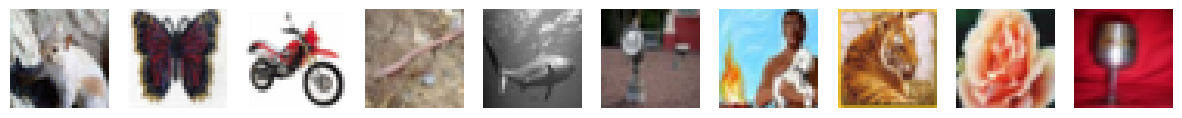

In [1]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# Mostrar 10 imágenes aleatorias
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    idx = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[idx])
    axes[i].axis('off')
plt.show()

## 🔹 Estrategia 1: Transfer Learning + Fine-Tuning

### 📦 Preparación de los datos
Redimensionamiento, normalización y creación de generadores de datos.

In [2]:
# Importamos herramientas necesarias
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

# Definimos tamaño objetivo para las imágenes (ResNet50 espera 224x224) y el tamaño del lote
IMG_SIZE = 224
BATCH_SIZE = 32

# Generador de datos de entrenamiento con augmentación + preprocesado ResNet50
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # aplica el mismo preprocesado que ResNet50 usó en ImageNet
    rotation_range=15,                         # rotación aleatoria (máx 15°)
    width_shift_range=0.1,                     # desplazamiento horizontal aleatorio
    height_shift_range=0.1,                    # desplazamiento vertical aleatorio
    horizontal_flip=True                       # voltea aleatoriamente las imágenes horizontalmente
)

# Generador de datos de test (sin augmentación, solo preprocesado)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generadores de imágenes para entrenamiento y test, con resize aplicado
train_generator = train_datagen.flow(
    tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)),  # redimensiona cada imagen a 224x224
    y_train,                                         # etiquetas del conjunto de entrenamiento
    batch_size=BATCH_SIZE                           # tamaño del lote
)

test_generator = test_datagen.flow(
    tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)),   # redimensiona imágenes de test
    y_test,                                          # etiquetas del conjunto de test
    batch_size=BATCH_SIZE                           # tamaño del lote
)


### 🔍 Comparación de arquitecturas preentrenadas
Probaremos al menos dos modelos como ResNet50 y MobileNetV2.

### ResNet50 preentrenado (sin capas superiores)

#### Modelaje y explicación del modelo

In [3]:
# Importamos componentes clave para construir el modelo
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargamos la arquitectura base ResNet50 sin su parte superior (cabeza de clasificación de ImageNet)
base_model = ResNet50(
    weights='imagenet',               # Usamos pesos preentrenados en ImageNet
    include_top=False,                # Quitamos las capas de clasificación final
    input_tensor=Input(shape=(224, 224, 3))  # Definimos forma de entrada (reajustada a 224x224 RGB)
)

# Congelamos todas las capas del modelo base (no se entrenan en esta fase)
base_model.trainable = False

# Construimos el top model (cabeza personalizada para CIFAR100)
x = base_model.output                            # Tomamos la salida de ResNet50
x = GlobalAveragePooling2D()(x)                  # Reducción de dimensión, convierte mapas en un vector
x = Dense(256, activation='relu')(x)             # Capa densa intermedia con 256 unidades y ReLU
x = Dropout(0.5)(x)                               # Dropout del 50% para prevenir sobreajuste
output = Dense(100, activation='softmax')(x)     # Capa final con 100 clases (CIFAR100)

# Conectamos la entrada y salida del modelo final
modelo = Model(inputs=base_model.input, outputs=output)

# Compilamos el modelo
modelo.compile(
    optimizer=Adam(learning_rate=0.001),              # Optimizador Adam con lr inicial
    loss='sparse_categorical_crossentropy',           # Loss para clasificación multiclase con etiquetas enteras
    metrics=['accuracy']                              # Métrica principal: accuracy
)

# Mostramos resumen del modelo con todas sus capas y parámetros
modelo.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**🧾 Resumen del modelo (explicación)**

- El modelo está compuesto por **ResNet50 como base (sin su top)** y un **top model personalizado**.
- Se están usando pesos **preentrenados en ImageNet**, y todas las capas de ResNet50 están **congeladas**, es decir, **no se reentrenan en esta fase**.
- El top model incluye:
  - Una capa de **GlobalAveragePooling2D** que reduce la dimensión del output de ResNet50.
  - Una capa **Dense (256, ReLU)** que actúa como clasificador intermedio.
  - Un **Dropout del 50%** para evitar sobreajuste.
  - Una capa **Dense final de 100 neuronas con softmax**, correspondiente a las 100 clases de CIFAR100.

**📊 Parámetros del modelo:**
- **Total de parámetros**: 24,137,956  
  Es la suma de todos los pesos del modelo completo (base + top).
- **Parámetros entrenables**: 550,244  
  Solo corresponden al top model, que es la parte que estamos entrenando ahora.
- **Parámetros no entrenables**: 23,587,712  
  Son los pesos de la ResNet50, que están congelados y **no se actualizan** durante esta fase.

✅ En esta fase solo estamos enseñando a la “cabeza” del modelo cómo clasificar imágenes de CIFAR100 usando lo que ResNet ya sabe.


#### Entrenamiento de la primera fase (solo top model)

In [ ]:
# Callback para parar el entrenamiento si no mejora en 5 épocas seguidas
early_stop = EarlyStopping(
    patience=5,                     # Número de épocas sin mejora antes de parar
    restore_best_weights=True      # Vuelve a los pesos con mejor validación
)

# Callback para reducir el learning rate si no mejora en 3 épocas
reduce_lr = ReduceLROnPlateau(
    patience=3,                    # Épocas sin mejora antes de reducir el LR
    factor=0.5,                    # Reduce el LR a la mitad
    verbose=1                      # Muestra mensaje cuando se reduzca el LR
)

# Entrenamiento del modelo (top model solamente, ResNet50 sigue congelado)
history = model.fit(
    train_generator,               # Generador de datos con augmentación y preprocesado
    epochs=20,                     # Número máximo de épocas
    validation_data=test_generator,  # Validación sobre el set de test
    callbacks=[early_stop, reduce_lr]  # Callbacks para optimización del proceso de entrenamiento
)



### MobileNetV2

## 🔸 Estrategia 2: Red desde cero (Custom CNN)

### 🧱 Diseño de la arquitectura personalizada
Aquí definimos una CNN desde cero con técnicas de optimización.

In [ ]:
# Aquí irá el modelo CNN diseñado desde cero, con batch normalization, dropout y otras técnicas.

## 📈 Comparación y evaluación

In [ ]:
# Código para comparar las métricas de ambas estrategias (accuracy, curvas de pérdida, etc.)

## 🧠 Conclusiones

Aquí se discutirán los resultados obtenidos con ambas estrategias, sus ventajas, desventajas y posibles mejoras futuras.